# Point estimators

* A point estimator is an algorithm or function that given a set of data points $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ outputs a real value.
* A good point estimator tries to approximate some characteristic of the data set and its value converges to the true value in the process $n\to \infty$

## I. Theoretical formalisation
* Let $\mathcal{D}_{\alpha_1,\alpha_2,\ldots,\alpha_k}$ be a parametrised distribution that generates samples $\boldsymbol{x}_i$. 
* Then we might want to infer what are the values of $\alpha_1,\alpha_2,\ldots,\alpha_k$ form obsereved data.
* We can use point estimator $f_i$ for estimating the value of $\alpha_i$.
* As data generation is random process point estimator outcomes $\hat{\alpha}_1=f_i(\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n)$ are also random.

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from plotnine import *

from convenience import head, tail
from convenience import combine_categories

In [2]:
def data_sampler(n:int, mu:float=0,  sigma: float=1) -> Series:
    """
    Data generator that generates n values form the normal distribution N(mu, sigma)
    """
    
    return Series(np.random.normal(loc=mu, scale=sigma, size = n))

In [3]:
data_sampler(10)

0   -0.318364
1   -0.775358
2    0.452169
3   -0.732391
4    0.459574
5    0.829068
6    0.381766
7   -0.613950
8    0.419873
9    0.641727
dtype: float64

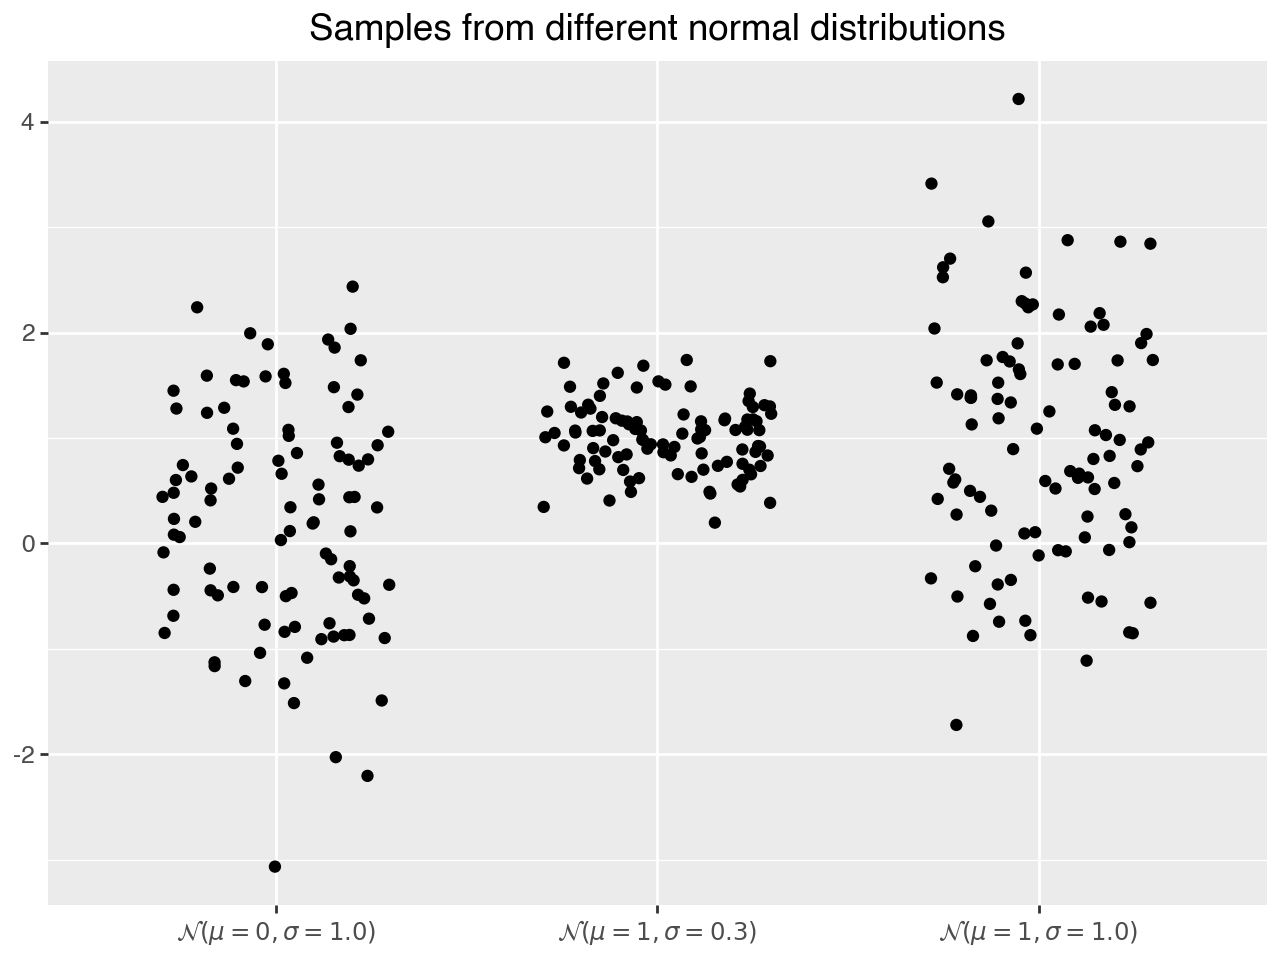

In [4]:
df = pd.concat([
    DataFrame(data_sampler(100, mu=0, sigma=1.0), columns=['x']).assign(parameters='$\mathcal{N}(\mu=0, \sigma=1.0)$'),
    DataFrame(data_sampler(100, mu=1, sigma=1.0), columns=['x']).assign(parameters='$\mathcal{N}(\mu=1, \sigma=1.0)$'),
    DataFrame(data_sampler(100, mu=1, sigma=0.3), columns=['x']).assign(parameters='$\mathcal{N}(\mu=1, \sigma=0.3)$')], axis=0)    

ggplot(df) + geom_jitter(aes(x='parameters', y='x'), width=0.3) + ylab('') + xlab('') + ggtitle('Samples from different normal distributions')

For this particular data distribution there are parameters we can estimate $\mu$ and $\sigma$. 
Let us consider three point estimators for the $\mu$ value

In [5]:
def f0(x):
    return 0

def f1(x):
    return np.mean(x)

def f2(x):
    return np.random.uniform(-1,1,1)

Then the corresponding distributions of the point estimator values can be empirically measured.

In [17]:
k = 1000
sample_size = [1, 10, 50, 100, 250, 500, 750, 1000] 

result = (combine_categories({'sample_size': sample_size, 'method': ['f0', 'f1', 'f2'], 'experiment': list(range(k))})
         .assign(value = np.nan)
         .set_index(['sample_size', 'method', 'experiment'])
         .sort_index())
result.head()

value
sample_size method experiment       
1           f0     0             NaN
                   1             NaN
                   2             NaN
                   3             NaN
                   4             NaN

In [31]:
from tqdm.notebook import trange

for size in sample_size:
    for experiment in trange(k, desc = 'Size: {:_>4}'.format(size)):
        data = data_sampler(size)
        result.loc[(size, 'f0', experiment), 'value'] = f0(data)
        result.loc[(size, 'f1', experiment), 'value'] = f1(data)
        result.loc[(size, 'f2', experiment), 'value'] = f2(data)
tail(result)

Size: ___1:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: __10:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: __50:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: _100:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: _250:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: _500:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: _750:   0%|          | 0/1000 [00:00<?, ?it/s]

Size: 1000:   0%|          | 0/1000 [00:00<?, ?it/s]

value
sample_size method experiment          
1000        f2     995        -0.363258
                   996         0.787669
                   997        -0.120128
                   998         0.948604
                   999         0.424336

Let us explore the resulting distributions

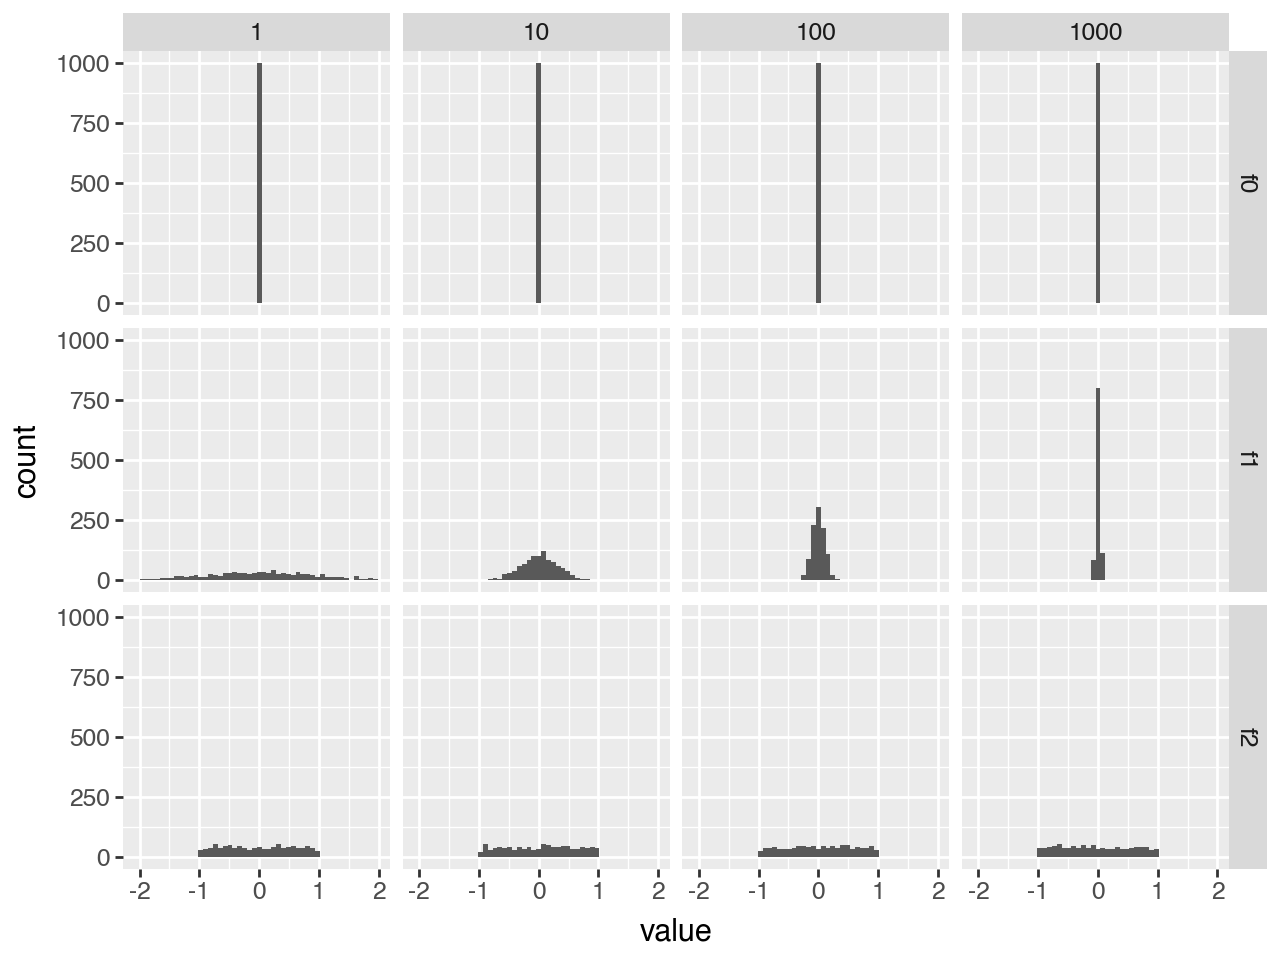

In [32]:
# Drop values outside [-2, 2] for clarity
p = ggplot(result
           .loc[[1, 10, 100, 1000]]
           .reset_index()
           .pipe(lambda df: df.loc[abs(df['value'])<= 2]))
p = p + geom_histogram(aes(x='value'), bins=50)
p = p + facet_grid(rows=['method'], cols=['sample_size']) 
p

## II. Bias and variance 

* A point estimator does not have to provide the correct answer.
* A point estimator is unbiased if its expected value coincides with the true parameter value.
* A statistical variance of the point estimator shows how much a point estimate fluctuates.
* A point estimator is reasonable if its variance decreases as $n\to\infty$.
* A point estimator is asymptotocally consistent if the estimator converges in probabilty to the true value.
* A biased estimator can be also asymptotocally consistent and more effective.

In [38]:
sdf = (result
       .groupby(['method', 'sample_size'])
       .aggregate(
           mean = ('value', 'mean'), 
           std  = ('value', 'std'),
           q05  = ('value', lambda x: np.quantile(x, q=0.05)),
           q50  = ('value', lambda x: np.quantile(x, q=0.50)),
           q95  = ('value', lambda x: np.quantile(x, q=0.95)))
      )
tail(sdf)

mean       std       q05       q50       q95
method sample_size                                                  
f2     100          0.019777  0.564741 -0.876894  0.028075  0.899900
       250          0.015767  0.582410 -0.914793  0.035899  0.915576
       500         -0.038162  0.588350 -0.924719 -0.058801  0.880812
       750         -0.013181  0.577261 -0.886158 -0.018593  0.910611
       1000        -0.029385  0.579065 -0.911494 -0.062435  0.896016

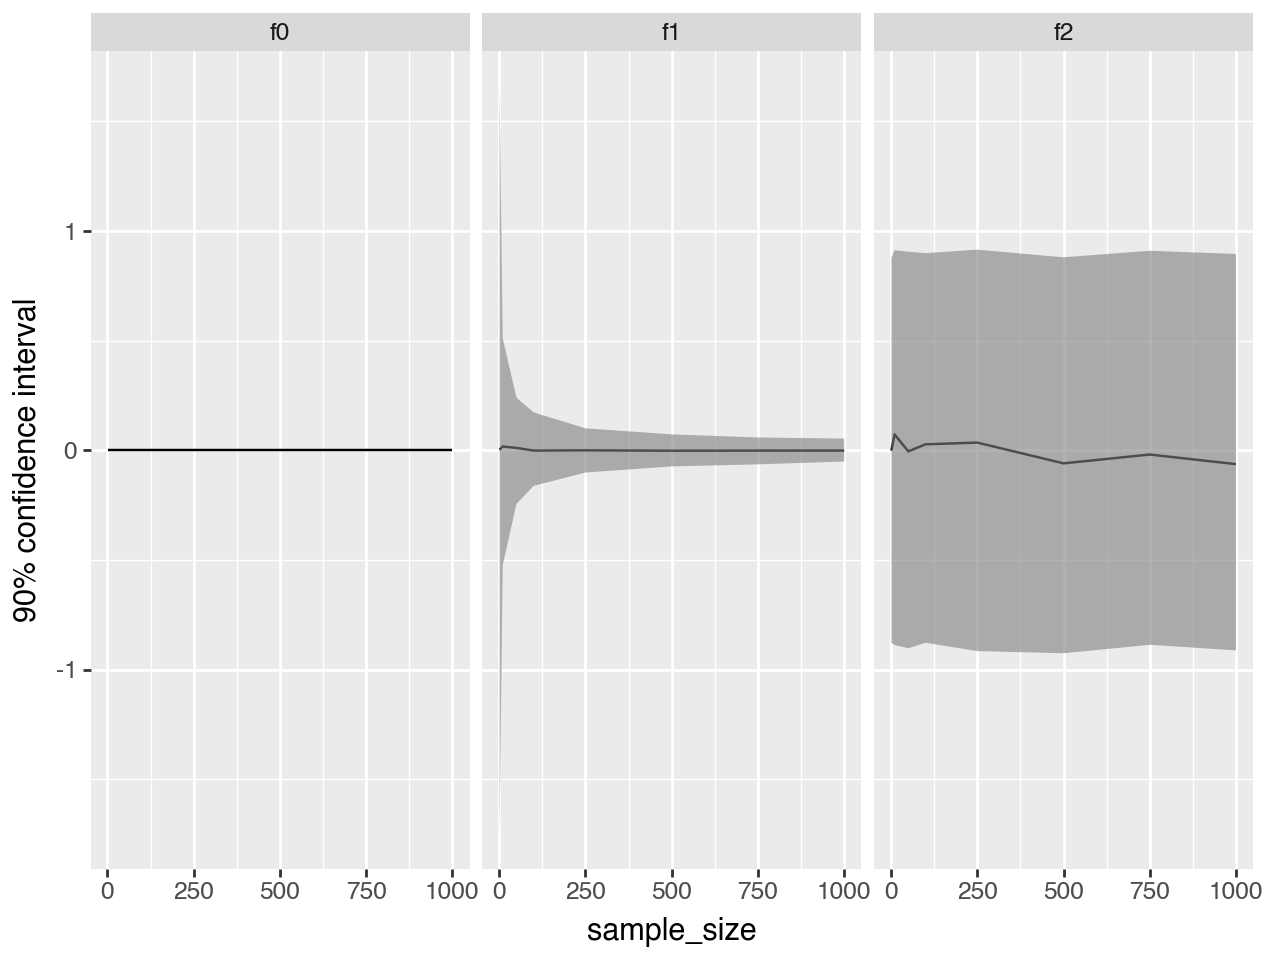

In [39]:
p = ggplot(sdf.reset_index())
p = p + geom_line(aes(x = 'sample_size', y = 'q50'))
p = p + geom_ribbon(aes(x = 'sample_size', ymin = 'q05', ymax = 'q95'), fill='grey', alpha=0.6)
p = p + facet_wrap('method')
p + scale_y_continuous(name = '90% confidence interval')

## III. Moment matching and confidence intervals

* Reasonable point estimators have a distribution that is close to a normal distribution.
* Normal distribution is fixed by mean and variance.
* If we can estimate mean and variance of the point estimator we can fix corresponding normal approximation. 
* It is straightforward to find confidence intervals (typical regions) for a normal distribution. 

### Mean and variance of  the second point estimator

The second point estimator $f_1$ in our examples is actually a reasonable estimator and thus we can define normal appoximation.

In [42]:
df = result.reset_index('sample_size').loc['f1']
display(head(df))

sdf = (df
       .groupby('sample_size')
       .aggregate(mean = ('value', 'mean'), std  = ('value', 'std')))
sdf

,sample_size,value
experiment,,
0,1,0.710369
1,1,-0.271585
2,1,-1.401529
3,1,0.466261
4,1,-0.790018


,mean,std
sample_size,,
1,-0.020578,1.009729
10,0.010510,0.313678
50,0.003580,0.144199
100,0.002678,0.102878
250,-0.000298,0.061615
500,-0.000485,0.044303
750,-0.000805,0.037075
1000,0.001327,0.032169


### Theoretical histogram approximation

* Let us now use moment matching to compute expected histogram values for various dataset sizes. 
* We use cumulative probability density function for the normal distribution from `scipy.stats` for that.



,x,sample_size,prob
0,-4.00,1,0.000043
1,-3.75,1,0.000111
2,-3.50,1,0.000268
3,-3.25,1,0.000608
4,-3.00,1,0.001296


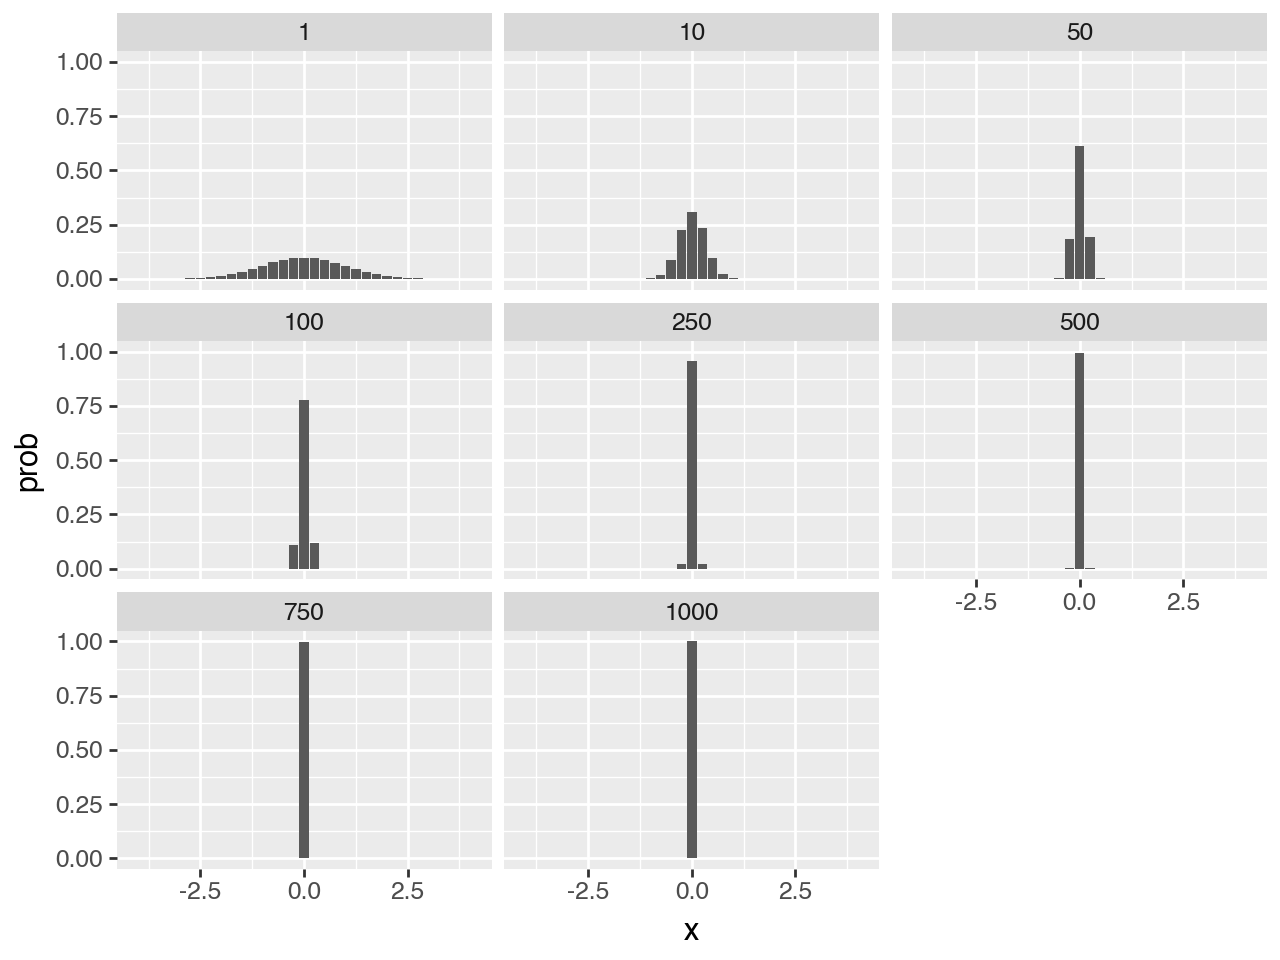

In [43]:
from scipy.stats import norm

tdf = pd.concat([DataFrame({'x': [0.25 * x  for x  in range(-16,17)]})
                   .assign(sample_size=size)
                   .assign(
                       prob =  lambda df: 
                           norm.cdf(df['x'] + 0.125, loc=sdf.loc[size, 'mean'], scale=sdf.loc[size, 'std']) -
                           norm.cdf(df['x'] - 0.125, loc=sdf.loc[size, 'mean'], scale=sdf.loc[size, 'std'])
                    ) for size in sample_size])

display(head(tdf))

p = ggplot(tdf)
p = p + geom_col(aes(x = 'x', y = 'prob'))
p = p + facet_wrap('sample_size')
p

### Comparison with real values

* As there are 1000 samples we must rescale the theoretical probability distribution to match histogram counts. 

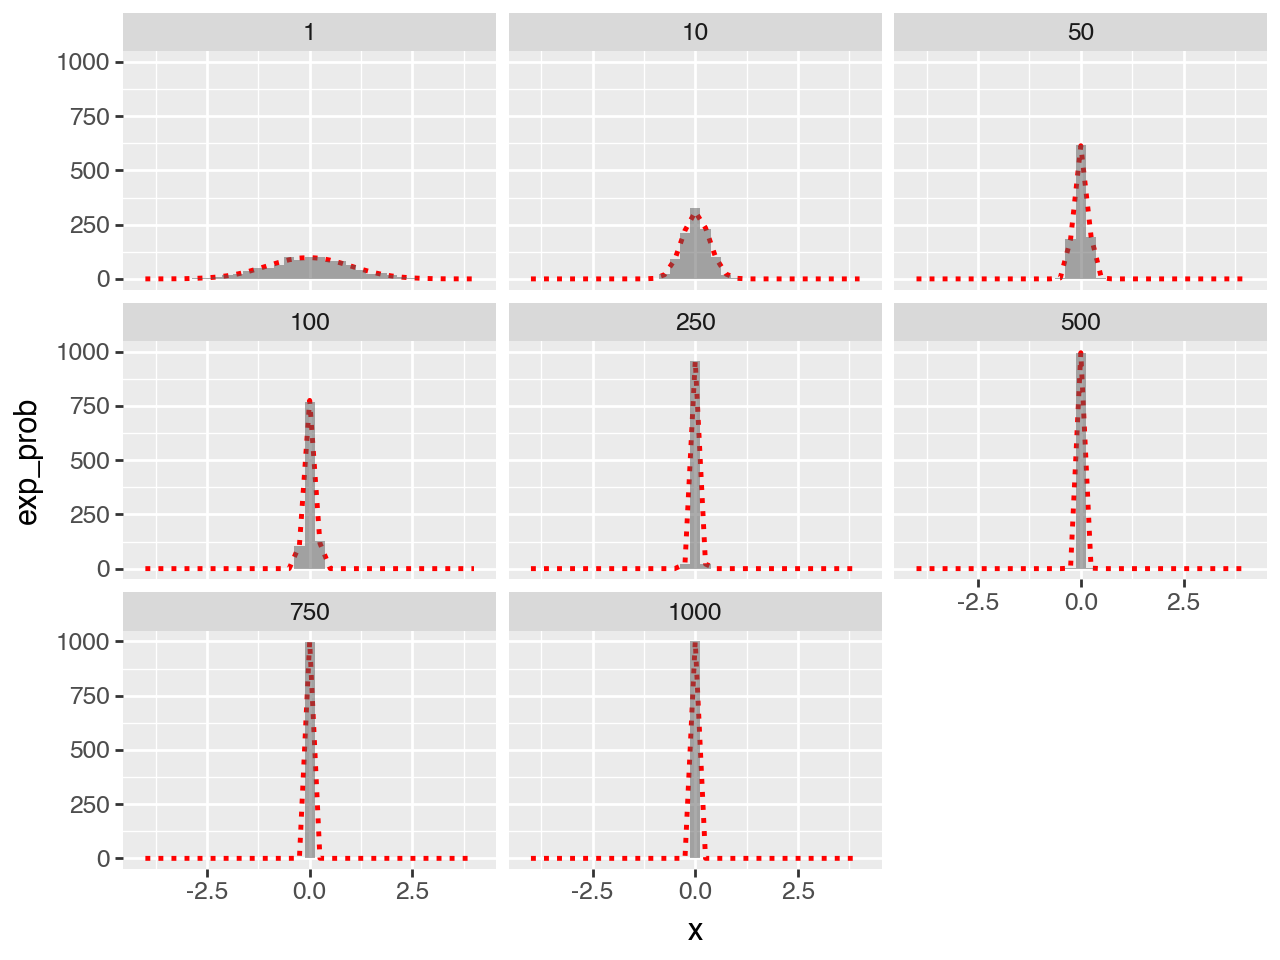

In [44]:
p = ggplot(tdf.assign(exp_prob = lambda df: df['prob'] * 1000))
p = p + geom_line(aes(x = 'x', y = 'exp_prob'), color='red', size=1, linetype=':')
p = p + geom_histogram(aes(x = 'value'), data=df, center=0, binwidth=0.25, alpha=0.5)
p = p + facet_wrap('sample_size')
p

## III. Mean value as a point estimator

Let us consider the case where 100 data points are samples from a normal distribution $\mathcal{N}(\mu=0, \sigma=1)$ and let the point estimator be 

\begin{align*}
  \widehat{\mu}=\frac{1}{100}\cdot\sum_{i=1}^n x_i
\end{align*}

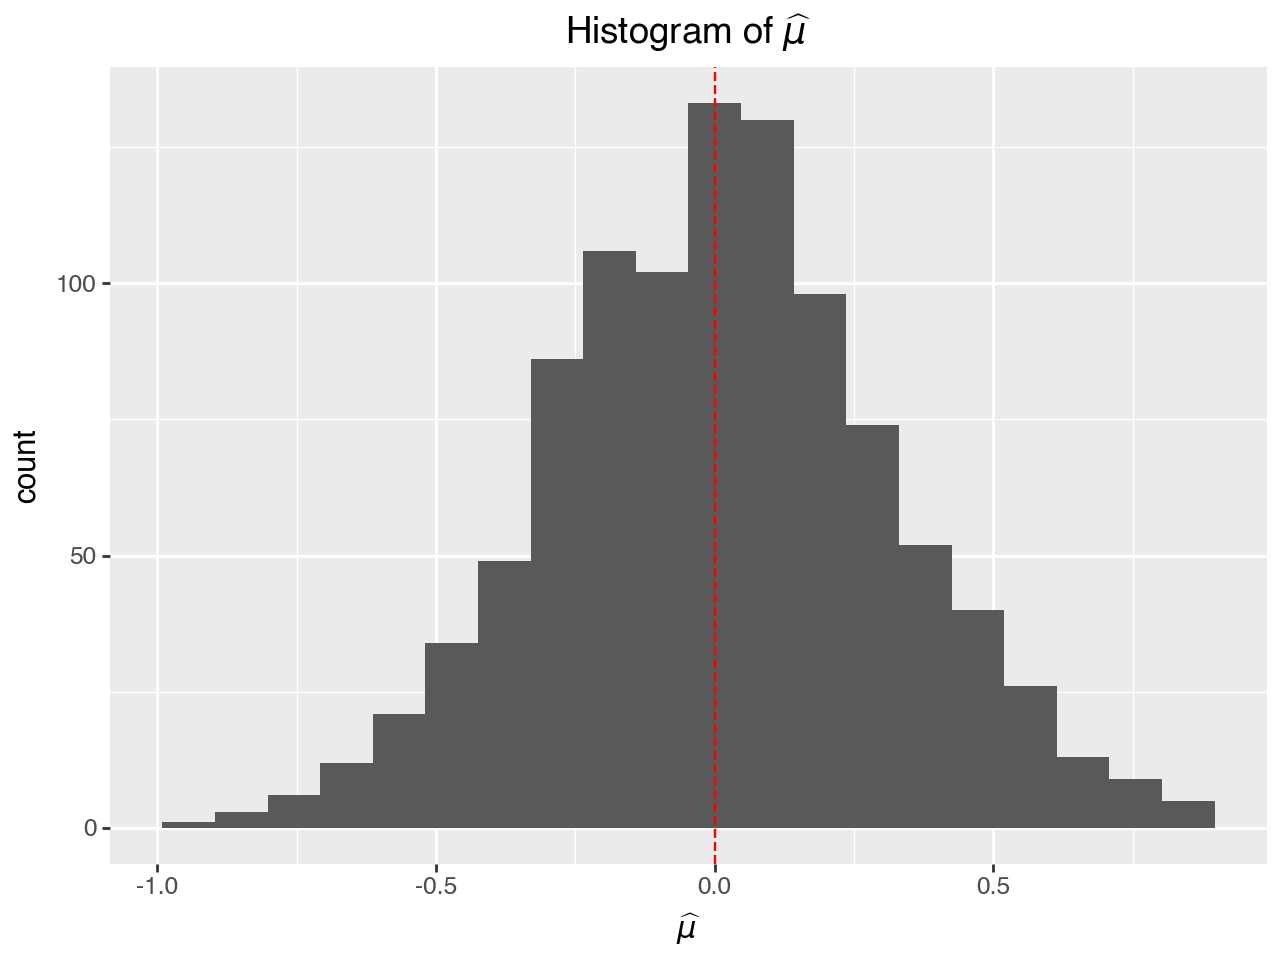

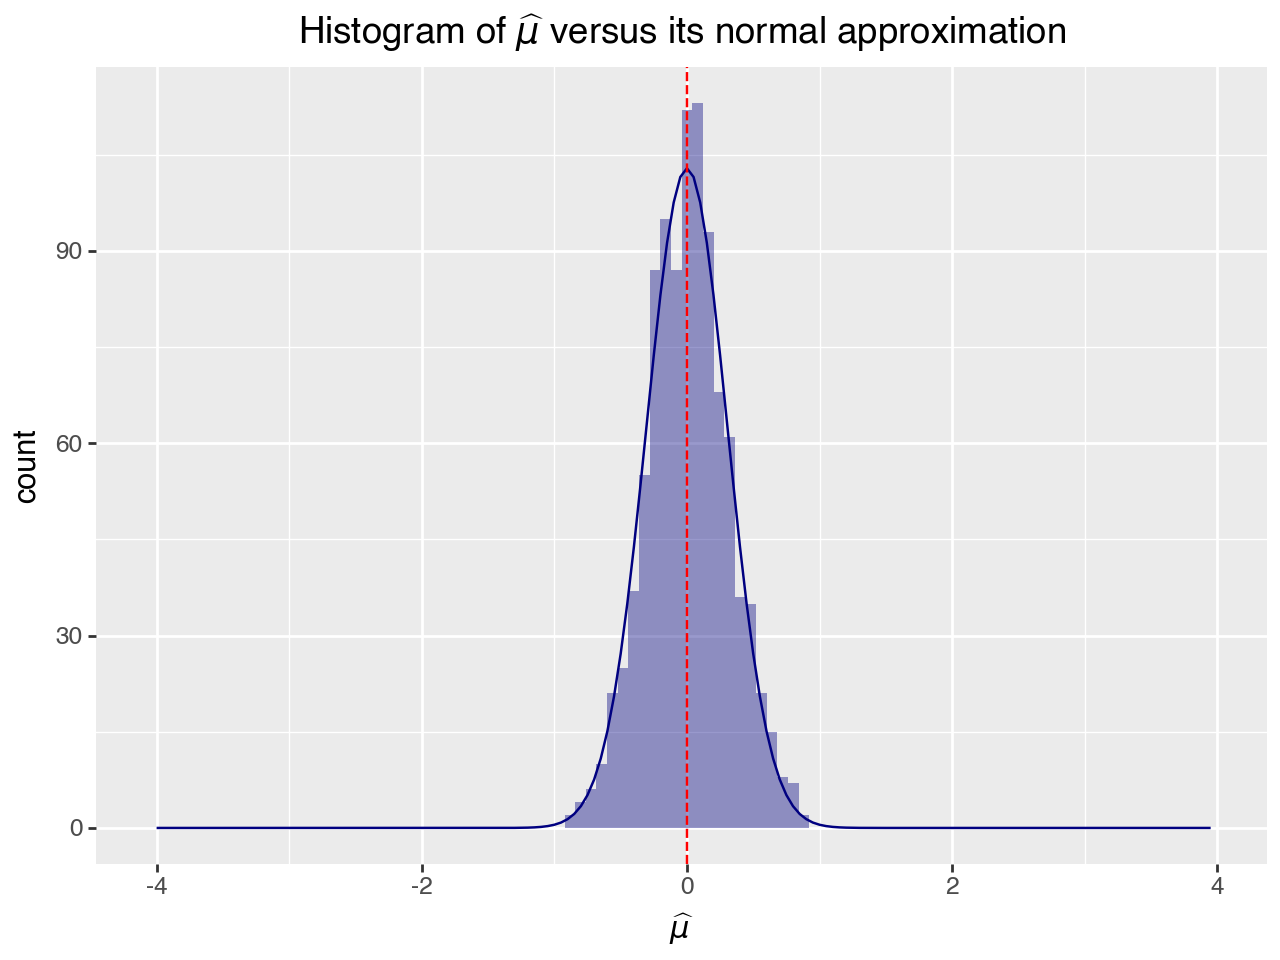

In [45]:
result = DataFrame([sum(data_sampler(1000))/100 for i in range(1000)], columns=[r'$\widehat{\mu}$'])
p  = ggplot(result) 
p += geom_histogram(aes(x=r'$\widehat{\mu}$'), bins=20) 
p += ggtitle('Histogram of $\widehat{\mu}$') 
p += geom_vline(xintercept=0, color='red', linetype='dashed')
display(p)

# Moment matching 
mean_mu = np.mean(result['$\widehat{\mu}$'])
std_mu = np.std(result['$\widehat{\mu}$'])

tdf = DataFrame({'x': [x  for x  in np.arange(-4, 4, 0.05)]}).assign(prob =  lambda df: norm.pdf(df['x'], loc=0, scale=std_mu) * 79)
p  = ggplot(tdf) 
p += ggtitle('Histogram of $\widehat{\mu}$ versus its normal approximation')
p += geom_histogram(aes(x=r'$\widehat{\mu}$'), bins=100, data=result, fill='navy', alpha=0.4)
p += geom_line(aes(x='x', y='prob'), color='navy')
p += geom_vline(xintercept=0, color='red', linetype='dashed')
p